In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def scale_data(data_list):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    all_data = preprocessing.scale(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
    data_list = [train_sst,train_t300,train_ua,train_va]
    train_sst,train_t300,train_ua,train_va = scale_data(data_list)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
    data_list = [train_sst2,train_t3002,train_ua2,train_va2]
    train_sst2,train_t3002,train_ua2,train_va2 = scale_data(data_list)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

(96318720, 4)
(2073600, 4)
Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.tight_layout()
        plt.show()

In [10]:
class CNN_Model(nn.Module):
    def __init__(self, embed_dim=128):
        super(CNN_Model, self).__init__()
#         self.block = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(128, 256, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.AdaptiveAvgPool2d((1, 1)))
        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
#         resnet.fc = nn.Linear(resnet.fc.in_features, 256)
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
        self.lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers=2, batch_first=True, bidirectional=True)
        self.avgpool = nn.AvgPool1d(12)
        self.linear = nn.Linear(256, 24)

    def forward(self, sst, t300, ua, va):
        x = torch.cat([sst.unsqueeze(2), t300.unsqueeze(2), ua.unsqueeze(2), va.unsqueeze(2)], dim=2) # b * 12 * 4 * 24 * 72
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.resnet(t_i).squeeze(-1).squeeze(-1) #  # b * 128
#             t_i = torch.flatten(t_i, start_dim=1)
            seq.append(t_i)
        x = torch.stack(seq).transpose(0,1) # b * 12 * 128
        x, _ = self.lstm(x) # b * 12 * 128
        x = self.avgpool(x.transpose(1,2)).squeeze(-1) # b * 128
        x = self.linear(x)  # b * 24
        return x

In [11]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [12]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 12.228248M


In [13]:
model

CNN_Model(
  (resnet): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Step: 0, Train Loss: 0.7904038429260254
Step: 20, Train Loss: 0.6661732792854309
Step: 40, Train Loss: 0.7929019927978516
Step: 60, Train Loss: 0.47473782300949097
Step: 80, Train Loss: 0.6097100377082825
Step: 100, Train Loss: 0.4535946547985077
Step: 120, Train Loss: 0.6197894811630249
Step: 140, Train Loss: 0.6190667152404785
Epoch: 1, Train loss: 0.5814289222024891
acskill_socre:19.449845793552317, rmse_score:19.541564071687773
Epoch: 1, Valid Score: -0.09171827813545619
Model saved successfully


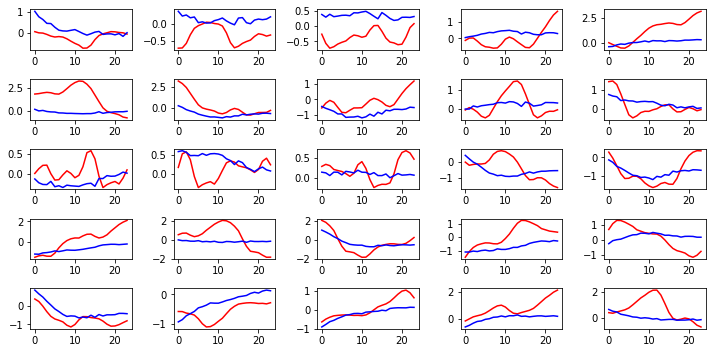

Step: 0, Train Loss: 0.4773370921611786
Step: 20, Train Loss: 0.45904335379600525
Step: 40, Train Loss: 0.49802741408348083
Step: 60, Train Loss: 0.6436893939971924
Step: 80, Train Loss: 0.41780775785446167
Step: 100, Train Loss: 0.520065426826477
Step: 120, Train Loss: 0.4368066191673279
Step: 140, Train Loss: 0.5812163352966309
Epoch: 2, Train loss: 0.4645622339967179
acskill_socre:17.40874381238492, rmse_score:19.605021443133573
Epoch: 2, Valid Score: -2.1962776307486536


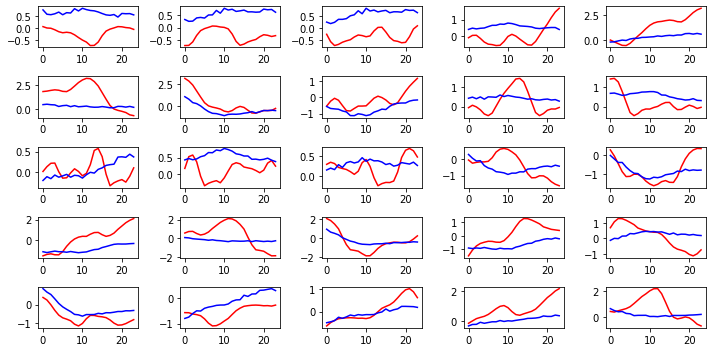

Step: 0, Train Loss: 0.5647366046905518
Step: 20, Train Loss: 0.4061325490474701
Step: 40, Train Loss: 0.2887973189353943
Step: 60, Train Loss: 0.38213133811950684
Step: 80, Train Loss: 0.344207763671875
Step: 100, Train Loss: 0.5769635438919067
Step: 120, Train Loss: 0.4114307761192322
Step: 140, Train Loss: 0.32521650195121765
Epoch: 3, Train loss: 0.39688631739110164
acskill_socre:19.862132174586982, rmse_score:19.152276486172937
Epoch: 3, Valid Score: 0.709855688414045
Model saved successfully


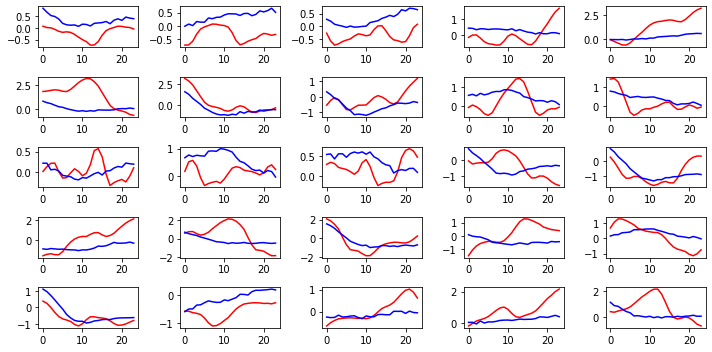

Step: 0, Train Loss: 0.341062992811203
Step: 20, Train Loss: 0.3290862739086151
Step: 40, Train Loss: 0.23166820406913757
Step: 60, Train Loss: 0.2595699429512024
Step: 80, Train Loss: 0.2293940633535385
Step: 100, Train Loss: 0.36876630783081055
Step: 120, Train Loss: 0.2618841528892517
Step: 140, Train Loss: 0.2796650826931
Epoch: 4, Train loss: 0.30046727559337877
acskill_socre:21.709391669238574, rmse_score:20.047811561202725
Epoch: 4, Valid Score: 1.6615801080358494
Model saved successfully


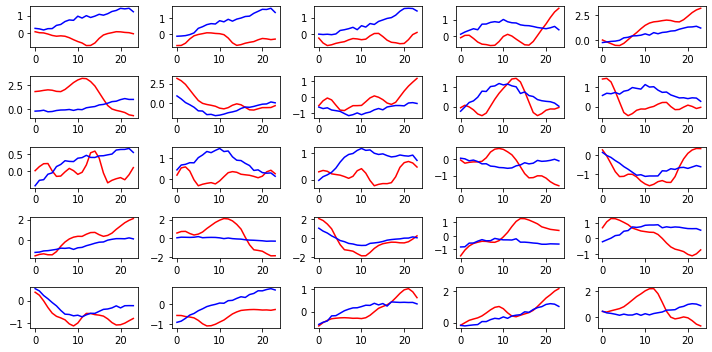

Step: 0, Train Loss: 0.21062123775482178
Step: 20, Train Loss: 0.23134386539459229
Step: 40, Train Loss: 0.2555665969848633
Step: 60, Train Loss: 0.21120235323905945
Step: 80, Train Loss: 0.29141128063201904
Step: 100, Train Loss: 0.19372570514678955
Step: 120, Train Loss: 0.1871078908443451
Step: 140, Train Loss: 0.22082176804542542
Epoch: 5, Train loss: 0.21273558709311158
acskill_socre:19.951805931923197, rmse_score:21.825247185432566
Epoch: 5, Valid Score: -1.8734412535093696


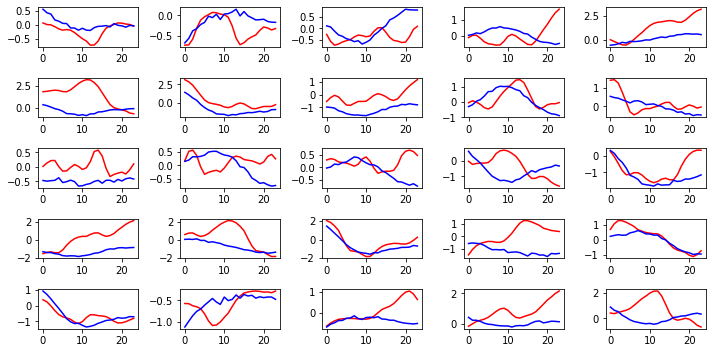

Step: 0, Train Loss: 0.12809352576732635
Step: 20, Train Loss: 0.17658738791942596
Step: 40, Train Loss: 0.16908323764801025
Step: 60, Train Loss: 0.09732836484909058
Step: 80, Train Loss: 0.20704114437103271
Step: 100, Train Loss: 0.10689522325992584
Step: 120, Train Loss: 0.17896698415279388
Step: 140, Train Loss: 0.1476903259754181
Epoch: 6, Train loss: 0.15394106063328378
acskill_socre:16.378575414132325, rmse_score:20.65332217126279
Epoch: 6, Valid Score: -4.274746757130465


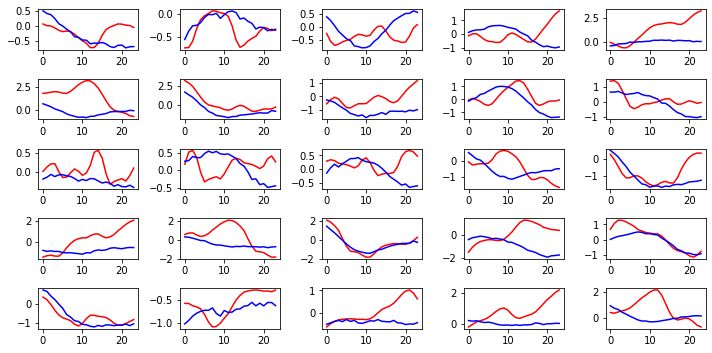

Step: 0, Train Loss: 0.10664854943752289
Step: 20, Train Loss: 0.12175904214382172
Step: 40, Train Loss: 0.11839622259140015
Step: 60, Train Loss: 0.11276529729366302
Step: 80, Train Loss: 0.10515537112951279
Step: 100, Train Loss: 0.08318140357732773
Step: 120, Train Loss: 0.11488169431686401
Step: 140, Train Loss: 0.14471131563186646
Epoch: 7, Train loss: 0.11754619738418762
acskill_socre:18.579411686313506, rmse_score:21.2793668530319
Epoch: 7, Valid Score: -2.699955166718393


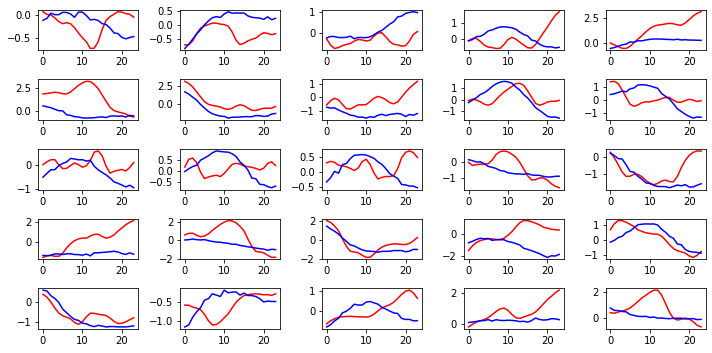

Step: 0, Train Loss: 0.07786446064710617
Step: 20, Train Loss: 0.08423139154911041
Step: 40, Train Loss: 0.09742701053619385
Step: 60, Train Loss: 0.07446034997701645
Step: 80, Train Loss: 0.12792427837848663
Step: 100, Train Loss: 0.06734254956245422
Step: 120, Train Loss: 0.08619442582130432
Step: 140, Train Loss: 0.06742969900369644
Epoch: 8, Train loss: 0.09682079026960347
acskill_socre:14.53460096730473, rmse_score:19.704715320480567
Epoch: 8, Valid Score: -5.170114353175837


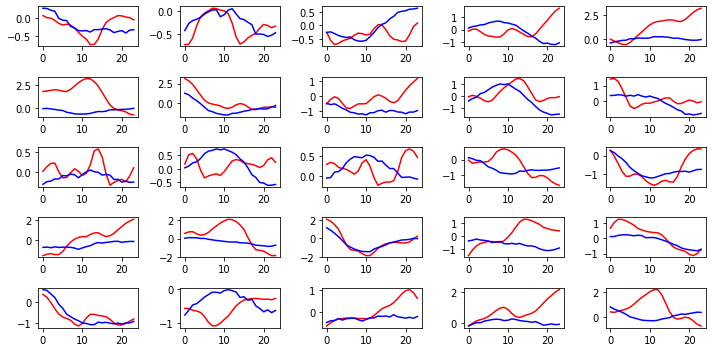

Step: 0, Train Loss: 0.08248180896043777
Step: 20, Train Loss: 0.1235475167632103
Step: 40, Train Loss: 0.08016561716794968
Step: 60, Train Loss: 0.07460238039493561
Step: 80, Train Loss: 0.1762649267911911
Step: 100, Train Loss: 0.08174057304859161
Step: 120, Train Loss: 0.09530596435070038
Step: 140, Train Loss: 0.07497185468673706
Epoch: 9, Train loss: 0.09775863937421204
acskill_socre:23.659499866326275, rmse_score:19.314564845957253
Epoch: 9, Valid Score: 4.344935020369022
Model saved successfully


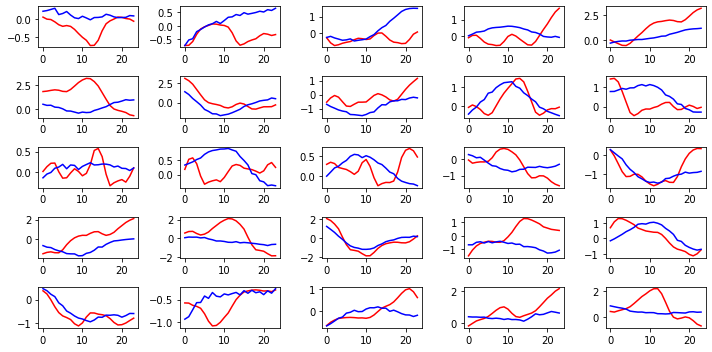

Step: 0, Train Loss: 0.06056743860244751
Step: 20, Train Loss: 0.08518904447555542
Step: 40, Train Loss: 0.06351043283939362
Step: 60, Train Loss: 0.0637127235531807
Step: 80, Train Loss: 0.10962840169668198
Step: 100, Train Loss: 0.06712055206298828
Step: 120, Train Loss: 0.09806328266859055
Step: 140, Train Loss: 0.10433898866176605
Epoch: 10, Train loss: 0.07936710188139791
acskill_socre:22.195085127380977, rmse_score:19.20060606312915
Epoch: 10, Valid Score: 2.994479064251827


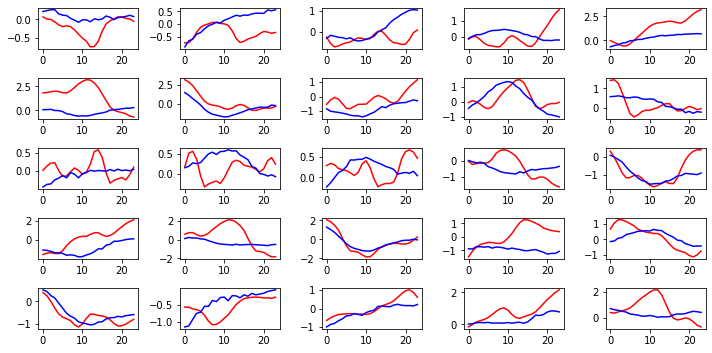

Step: 0, Train Loss: 0.07441441714763641
Step: 20, Train Loss: 0.04616028070449829
Step: 40, Train Loss: 0.10250037163496017


In [ ]:
train(num_epochs=30)

In [94]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

<All keys matched successfully>

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [17]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = scale_data(data_list)
    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [9]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [44]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [45]:
make_zip()

./result/test_0144-01-12.npy
